# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore") # This is to ignore warnings coming out of models due to low number of epochs, ...etc


In [2]:
random_state = 42
n_jobs=-1


# Importing the dataset, preprocessing and analyzing it

## Importing the dataset

In [3]:
dataset = pd.read_csv("datasets/COVID19_outcome.csv")


Let's view the shape of the dataset.

In [4]:
dataset.shape


(863, 15)

As described inside the project description, we have 14 features but as shown above, the shape of the dataset is (863, 15). Let's view the first 5 rows of the dataset.

In [5]:
dataset.head()


,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


As shown above there is an extra column called "Unnamed: 0" which contains the index of each row. Let's drop this column.

Note: Pandas named this column as it doesn't have a name.

In [6]:
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)


Now let's view the shape again.

In [7]:
dataset.shape


(863, 14)

Much better!!!

Now let's view some information about the dataset.

In [8]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 94.5 KB


Let's check if there are any missing values.

In [9]:
dataset.isna().sum()


location        0
country         0
gender          0
age             0
vis_wuhan       0
from_wuhan      0
symptom1        0
symptom2        0
symptom3        0
symptom4        0
symptom5        0
symptom6        0
diff_sym_hos    0
result          0
dtype: int64

Now Let's find out if there are any duplicate rows.

In [10]:
duplicates_count = 0
for x in dataset.duplicated():
    if x == True:
        duplicates_count += 1

print("Duplicates : ", duplicates_count)


Duplicates :  168


We have 168 rows that are duplicates. In this particular application we can't drop them.

In [11]:
# index = 0
# for x in dataset.duplicated():
#     if (x == True):
#         dataset.drop([index], axis=0, inplace= True)
#     index+=1


Let's view the duplicate rows again to make sure they are dropped.


In [12]:
# duplicates_count = 0
# for x in dataset.duplicated():
#     if (x == True):
#         duplicates_count+=1

# print("Duplicates : ", duplicates_count)


Note that the `.duplicated()` method ignores (marks as False) the first occurence of the duplicated rows and marks the rest as True. For example:

```python
temp = [[1,4,1],
        [1,5,1],
        [3,6,0],
        [8,4,1],
        [1,4,1],
        [1,4,0],
        [3,6,0],
        [5,1,1],
        [9,4,0],
        [1,7,0]]
pd.DataFrame(temp).duplicated()
```

will return:

```
0    False
1    False
2    False
3    False
4     True --> This row is a duplicate of row 0.
5    False
6     True --> This row is a duplicate of row 2.
7    False
8    False
9    False
dtype: bool
```


In [13]:
dataset.describe()


,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


## Let's work on the outliers

## Exploratory Data Analysis

### Visualizing Data Distributions

In [14]:
# dataset.hist(figsize=(16, 16))
# plt.show()


### Visualizing feature correlations

This is the covariance matrix

```
      0           1           2           ...  n
    -------------------------------------------------------
0   | Var(0)      Covar(0,1)  Covar(0,2)  ...  Covar(0,n) |
    -------------------------------------------------------
1   | Covar(1,0)  Var(1)      Covar(1,2)  ...  Covar(1,n) |
    -------------------------------------------------------
2   | Covar(2,0)  Covar(2,1)  Var(2)      ...  Covar(2,n) |
    -------------------------------------------------------
... | ...         ...         ...         ...  ...        |
    -------------------------------------------------------
n   | Covar(n,0)  Covar(n,1)  Covar(n,2)  ...  Var(n)     |
    -------------------------------------------------------
```

So for example:

${covariance}(X, Y) = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{n-1}$

The mean of variable $X$ is calculated as $\bar{X} = \frac{\sum_{i=1}^{n} X_i}{n}$, and the mean of variable $Y$ is calculated as $\bar{Y} = \frac{\sum_{i=1}^{n} Y_i}{n}$.

Let's calculate the `covariance(location,location)` OR `covariance(0,0)` OR `variance(location)` OR `variance(0)` and the `covariance(location,country)` OR `covariance(0,1)` to make sure that the covariance matrix is correct.

```python

# Calculating the covariance(location,location) OR covariance(0,0) OR variance(location) OR variance(0)

n = COVID_19_outcome_dataset.shape[0]

x1 = COVID_19_outcome_dataset.iloc[:,0].values
y1 = x1

x1bar = np.mean(x1)
y1bar = x1bar

v_x1 = np.sum((x1 - x1bar) ** 2)
v_y1 = np.sum((y1 - y1bar) ** 2)

cov1_numerator = np.sum((x1 - x1bar) * (y1 - y1bar))
cov1 = cov1_numerator / ( n - 1)

correlation1_coefficient = cov1_numerator / (np.sqrt(v_x1) * np.sqrt(v_y1))

correlation1_coefficient

```

Will return:

```
1.0000000000000002
```

```python

# Calculating the covariance(location,country) OR covariance(0,1)

n = COVID_19_outcome_dataset.shape[0]

x2 = COVID_19_outcome_dataset.iloc[:,0].values
y2 = COVID_19_outcome_dataset.iloc[:,1].values

x2bar = np.mean(x2)
y2bar = np.mean(y2)

v_x2 = np.sum((x2 - x2bar) ** 2)
v_y2 = np.sum((y2 - y2bar) ** 2)

cov2_numerator = np.sum((x2 - x2bar) * (y2 - y2bar))
cov2 = cov2_numerator / (n - 1)

correlation2_coefficient = cov2_numerator / (np.sqrt(v_x2) * np.sqrt(v_y2))

correlation2_coefficient

```

Will return:

```
0.3093467486067619
```

Let's check the correlation matrix.

```python

corr = COVID_19_outcome_dataset.drop("result",axis= 1, inplace= False).corr()

corr["location"]["location"]

```

Will return:

```
1.0
```

```python

corr = COVID_19_outcome_dataset.drop("result",axis= 1, inplace= False).corr()

corr["location"]["country"]

```

Will return:

```
0.30934674860676165
```



We drop the target column to view the correlations between the features BUT we set `inplace` to False so that the original dataset is not affected.

In [15]:
corr = dataset.corr()


#### Let's draw the heatmap.


Here we only show the high(>0.5) and low(<-0.5) corr graph.

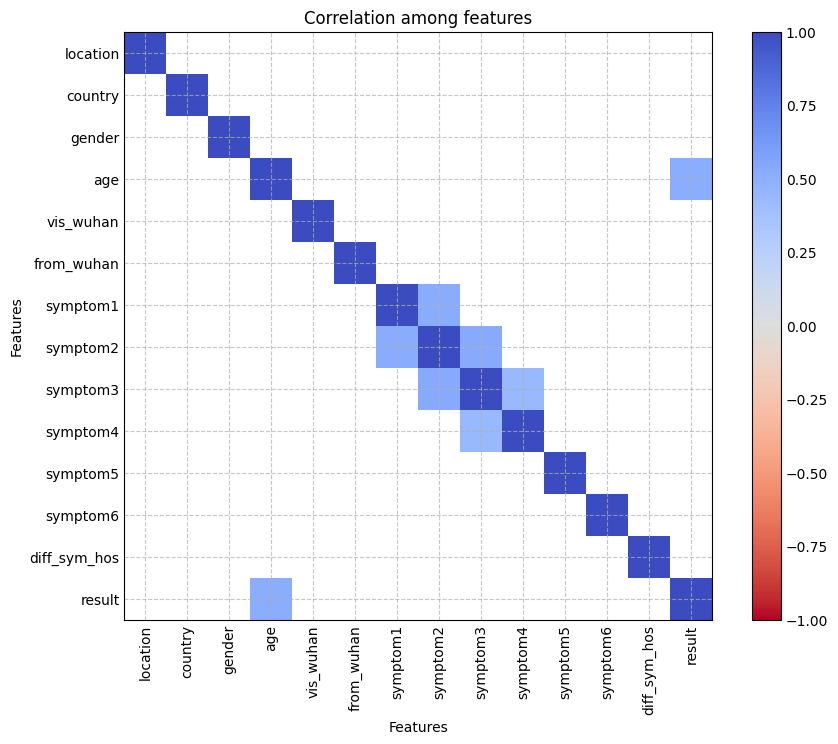

In [16]:
plt.style.use("_mpl-gallery-nogrid")

fig, ax = plt.subplots(figsize=(8, 6))
labels = dataset.columns
features_count = dataset.shape[1] + 1 # +1 for the result (target) column.
filtered_corr = corr[(corr > 0.4) | (corr < -0.4)]
hm = ax.imshow(
    filtered_corr, cmap="coolwarm_r", interpolation="nearest", aspect="equal"
)
ax.set_xticks(
    np.arange(0, features_count - 1), labels=labels, rotation="vertical", ha="center"
)  # X-axis scale and labels
ax.set_yticks(
    np.arange(0, features_count - 1), labels=labels
)  # Y-axis scale and labels
ax.grid(visible=True, linestyle="--", alpha=0.7)
ax.set(title="Correlation among features", xlabel="Features", ylabel="Features")
hm.set_clim((-1, 1))
cbar = fig.colorbar(mappable=hm)  # This is the color bar at the right
plt.show()


From the above heatmap, we observe that `symptom1` and `symptom2` are slightly correlated. Same with `symptom2` and `symptom3`.

# Model Building

## Splitting the dataset into the Training set and Test set

The training set will be used for validating the model (using Cross Validation) and the test set will be used for testing the model.

In [17]:
X = dataset.drop("result", axis=1, inplace=False).values
y = dataset["result"].values


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=random_state
)
for n, d in [
    ("X_train", X_train),
    ("X_test", X_test),
    ("y_train", y_train),
    ("y_test", y_test),
]:
    print(f"{n} Shape= {d.shape}")


X_train Shape= (690, 13)
X_test Shape= (173, 13)
y_train Shape= (690,)
y_test Shape= (173,)


## Scaling Data

This StandardScaler will scale the data to be inside the range of -3 and 3 inclusive.

In [19]:
sc = StandardScaler()
sc.fit_transform(X_train)
sc.transform(X_test)


array([[-0.82848612, -0.50783513,  0.2169658 , ...,  0.05286641,
         0.        ,  2.69412875],
       [-1.66769734, -0.63507052,  0.2169658 , ...,  0.05286641,
         0.        , -0.43391016],
       [ 0.5447686 , -1.14401205, -1.15648744, ...,  0.05286641,
         0.        , -0.43391016],
       ...,
       [ 1.00252017,  0.12834178,  0.2169658 , ...,  0.05286641,
         0.        , -0.43391016],
       [-1.43882155,  1.01898945,  0.2169658 , ...,  0.05286641,
         0.        , -0.43391016],
       [-1.64226669, -1.14401205,  0.2169658 , ...,  0.05286641,
         0.        ,  2.24726605]])

## Model Training and Prediction
 - K-Nearest Neighbors (KNN)
 - Logistic Regression (LR)
 - Naïve Bayes (NB)
 - Decision Trees (DT)
 - Support Vector Machines (SVM)
### We test these models and evaluate the predictive performance of each model.  

In [20]:
models = {
    "KNN": KNeighborsClassifier(n_jobs=n_jobs),
    "LR": LogisticRegression(random_state=random_state, n_jobs=n_jobs),
    "NB": GaussianNB(),
    # "DT": DecisionTreeClassifier(),
    # "SVM": SVC(),
}


In [21]:
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    prediction = {}
    for model_name, estimator in models.items():
        fitted_model = estimator.fit(X_train, y_train)
        prediction[model_name] = fitted_model.predict(X_test)
        print(f"{model_name}: { round(estimator.score(X_test, y_test),4)*100} %")
        print(classification_report(prediction[model_name], y_test))


In [22]:
train_and_evaluate(models, X_train, y_train, X_test, y_test)

KNN: 92.49000000000001 %
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       147
           1       0.76      0.73      0.75        26

    accuracy                           0.92       173
   macro avg       0.86      0.84      0.85       173
weighted avg       0.92      0.92      0.92       173



LR: 94.8 %
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       155
           1       0.68      0.94      0.79        18

    accuracy                           0.95       173
   macro avg       0.84      0.95      0.88       173
weighted avg       0.96      0.95      0.95       173

NB: 61.85000000000001 %
              precision    recall  f1-score   support

           0       0.57      0.98      0.72        86
           1       0.92      0.26      0.41        87

    accuracy                           0.62       173
   macro avg       0.74      0.62      0.56       173
weighted avg       0.74      0.62      0.56       173



## Let's check the Confusion Matrix of these outputs.

In [23]:
def draw_confusion_matrices(class_names: list[str], models: dict, X_test: np.ndarray, y_test: np.ndarray, normalize: str = None):
    plt.style.use("_mpl-gallery-nogrid")

    fig, axes = plt.subplots((len(models)//2)+1, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.1)

    np.set_printoptions(precision=2)

    for ((model_name, estimator), ax) in zip(models.items(), axes.flatten()):
        disp = ConfusionMatrixDisplay.from_estimator(
            estimator,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
            ax=ax,
            im_kw={"vmin": 0, "vmax": len(y_test)}, # Or len(X_test).
            text_kw={"color": "black", "size": 20, "ha": "center", "va": "center"},
        )
        disp.ax_.set_title(model_name)

    plt.show()

In [24]:
class_names = ["Death", "Recovered"]


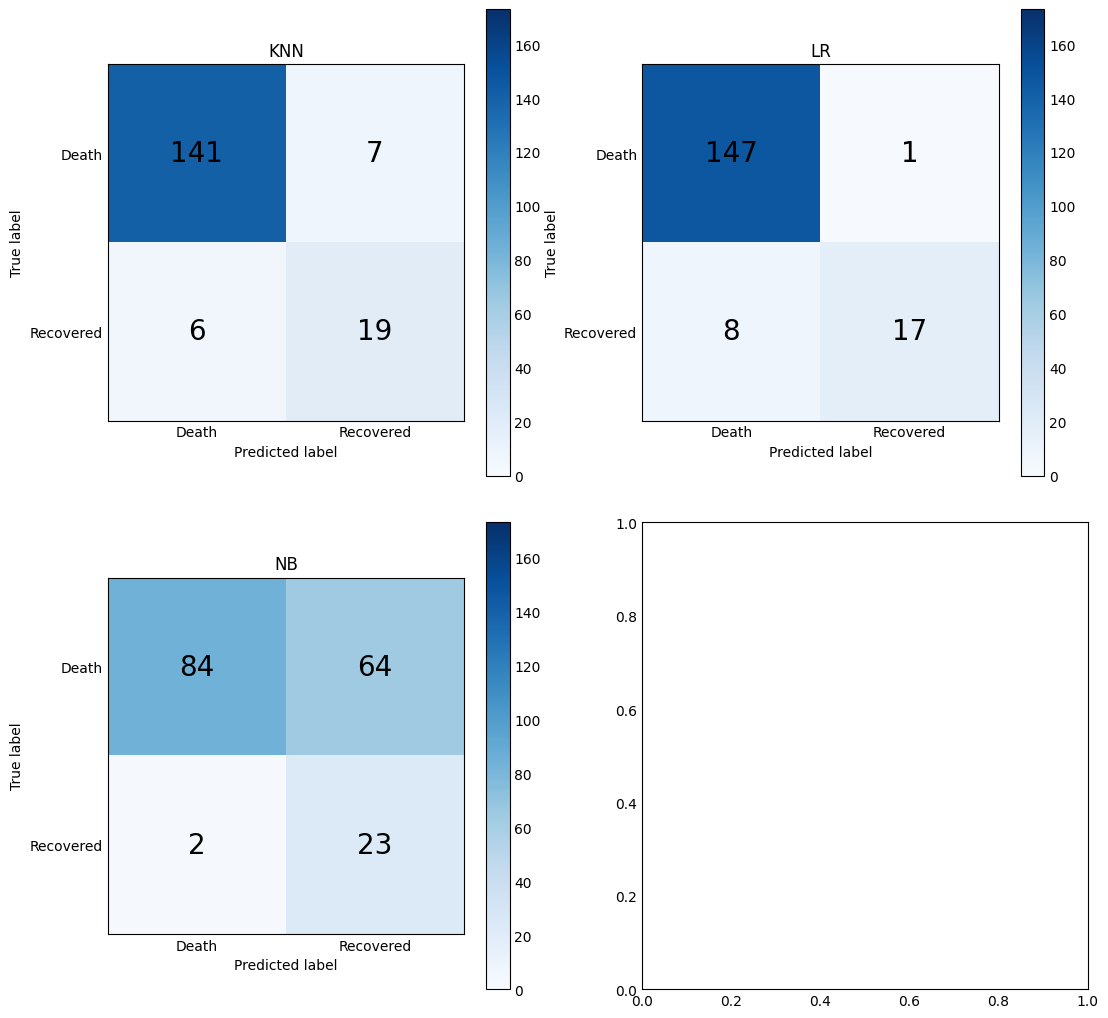

In [25]:
draw_confusion_matrices(class_names, models, X_test, y_test)

From the Classification Report and Confusion Matrix, we can observe that the performance of the GaussianNB model is noticeably inferior to the others.

These models have an accuracy rate of 90% or above in their predictions, except for the GaussianNB.

We are interested more in the Recall score of the positive class (COVID-19 positive) as we want to minimize the number of False Negatives (FN) as much as possible. We want to minimize the number of False Negatives (FN) because we don't want to tell a patient that he/she will recover when he/she is actually going to die. This is a very dangerous situation.

From the above results, we can observe that the KNN has 6 False Negatives (FN), the Logistic Regression has 8 False Negatives (FN), and the GaussianNB has 2 False Negatives (FN).

## Cross Validation

In [26]:
def cross_validate_model(estimator: ClassifierMixin, scoring: list[str], X_train: np.ndarray, y_train: np.ndarray, cv: int) -> np.ndarray:
    scores = cross_validate(
        estimator,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs
    )
    print(f"recall : {round(np.mean(scores['test_recall']), 4)}, f1 : {round(np.mean(scores['test_f1']), 4)} ")
    return scores
        

### Getting best parameters for KNN

In [27]:
cv=10 # 5-fold cross validation for each model


In [28]:
scoring=["recall", "f1"]


We choose n_neighbors to be an odd number because we have 2 classes and we don't want to have a tie.

In [29]:
n_neighbors_values: np.ndarray = np.arange(3, 30, 2)
leaf_size_values: np.ndarray = np.arange(10, 100, 10)
best_n_neighbors = n_neighbors_values[0]
best_n_neighbors_recall = 0.0
best_leaf_size = leaf_size_values[0]
best_leaf_size_recall = 0.0
for (n_neighbors, leaf_size) in zip(n_neighbors_values, leaf_size_values):
    estimator0 = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)
    scores = cross_validate_model(estimator0, scoring, X_train, y_train, cv)
    if np.mean(scores['test_recall']) > best_n_neighbors_recall:
        best_n_neighbors_recall = np.mean(scores['test_recall'])
        best_n_neighbors = n_neighbors
    estimator1 = KNeighborsClassifier(leaf_size=leaf_size, n_jobs=n_jobs)
    scores = cross_validate_model(estimator1, scoring, X_train, y_train, cv)
    if np.mean(scores['test_recall']) > best_leaf_size_recall:
        best_leaf_size_recall = np.mean(scores['test_recall'])
        best_leaf_size = leaf_size


recall : 0.7069, f1 : 0.7413 
recall : 0.6472, f1 : 0.7277 
recall : 0.6472, f1 : 0.7222 
recall : 0.6472, f1 : 0.7222 
recall : 0.5847, f1 : 0.6626 
recall : 0.6472, f1 : 0.7222 
recall : 0.5264, f1 : 0.6143 
recall : 0.6472, f1 : 0.7277 
recall : 0.4778, f1 : 0.5977 
recall : 0.6472, f1 : 0.7277 
recall : 0.4431, f1 : 0.5723 
recall : 0.6472, f1 : 0.7277 
recall : 0.4764, f1 : 0.59 
recall : 0.6472, f1 : 0.7277 
recall : 0.4264, f1 : 0.5515 
recall : 0.6472, f1 : 0.7222 
recall : 0.4403, f1 : 0.5587 
recall : 0.6472, f1 : 0.7222 


In [30]:
print(f"Best n_neighbors : {best_n_neighbors}, Best leaf_size : {best_leaf_size}")
print(f"Best n_neighbors recall : {best_n_neighbors_recall}, Best leaf_size recall : {best_leaf_size_recall}")

Best n_neighbors : 3, Best leaf_size : 10
Best n_neighbors recall : 0.7069444444444444, Best leaf_size recall : 0.6472222222222223


### Getting best parameters for Logistic Regression

In [31]:
C_values: np.ndarray = np.logspace(-3, 3, 20)
best_C = C_values[0]
best_C_recall = 0
for C in C_values:
    estimator0 = LogisticRegression(C=C, random_state=random_state, n_jobs=n_jobs)
    scores = cross_validate_model(estimator0, scoring, X_train, y_train, cv)
    if np.mean(scores['test_recall']) > best_C_recall:
        best_C_recall = np.mean(scores['test_recall'])
        best_C = C



recall : 0.5389, f1 : 0.6489 


recall : 0.5639, f1 : 0.6667 
recall : 0.6, f1 : 0.6908 
recall : 0.6222, f1 : 0.6998 
recall : 0.575, f1 : 0.6537 
recall : 0.5861, f1 : 0.6502 
recall : 0.5986, f1 : 0.6507 
recall : 0.6111, f1 : 0.6621 
recall : 0.6222, f1 : 0.6827 
recall : 0.6361, f1 : 0.6829 
recall : 0.6694, f1 : 0.7027 
recall : 0.6472, f1 : 0.6849 
recall : 0.6597, f1 : 0.694 
recall : 0.6833, f1 : 0.7155 
recall : 0.6583, f1 : 0.6902 
recall : 0.6583, f1 : 0.7049 
recall : 0.7056, f1 : 0.7253 
recall : 0.6708, f1 : 0.7035 
recall : 0.6819, f1 : 0.7033 
recall : 0.6833, f1 : 0.7147 


In [32]:
print(f"Best C : {best_C}")
print(f"Best C recall : {best_C_recall}")

Best C : 112.88378916846884
Best C recall : 0.7055555555555555


### Getting best parameters for Naïve Bayes

In [33]:
var_smoothing_values: np.ndarray = np.logspace(-9, 0, 20)
best_var_smoothing = var_smoothing_values[0]
best_var_smoothing_recall = 0
for var_smoothing in var_smoothing_values:
    estimator0 = GaussianNB(var_smoothing=var_smoothing)
    scores = cross_validate_model(estimator0, scoring, X_train, y_train, cv)
    if np.mean(scores['test_recall']) > best_var_smoothing_recall:
        best_var_smoothing_recall = np.mean(scores['test_recall'])
        best_var_smoothing = var_smoothing



recall : 0.9375, f1 : 0.3797 
recall : 0.925, f1 : 0.4108 
recall : 0.925, f1 : 0.4508 
recall : 0.925, f1 : 0.4937 
recall : 0.8875, f1 : 0.5172 
recall : 0.85, f1 : 0.5327 
recall : 0.8, f1 : 0.5464 
recall : 0.7764, f1 : 0.5641 
recall : 0.7389, f1 : 0.5629 
recall : 0.6778, f1 : 0.5464 
recall : 0.6069, f1 : 0.5161 
recall : 0.5361, f1 : 0.485 
recall : 0.5236, f1 : 0.4882 
recall : 0.5125, f1 : 0.5198 
recall : 0.5125, f1 : 0.5538 
recall : 0.4056, f1 : 0.5186 
recall : 0.3083, f1 : 0.4473 
recall : 0.0486, f1 : 0.0867 
recall : 0.0, f1 : 0.0 
recall : 0.0, f1 : 0.0 


In [34]:
print(f"Best var_smoothing : {best_var_smoothing}")
print(f"Best var_smoothing recall : {best_var_smoothing_recall}")

Best var_smoothing : 1e-09
Best var_smoothing recall : 0.9375


Now let's train the model with the best parameters.

In [35]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3, leaf_size=10, n_jobs=n_jobs),
    "LR": LogisticRegression(C=112.88378916846884, random_state=random_state, n_jobs=n_jobs),
    "NB": GaussianNB(var_smoothing=1000.0),
    # "DT": DecisionTreeClassifier(),
    # "SVM": SVC(),
}

In [36]:
train_and_evaluate(models, X_train, y_train, X_test, y_test)

KNN: 93.06 %
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       148
           1       0.76      0.76      0.76        25

    accuracy                           0.93       173
   macro avg       0.86      0.86      0.86       173
weighted avg       0.93      0.93      0.93       173

LR: 95.38 %
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       156
           1       0.68      1.00      0.81        17

    accuracy                           0.95       173
   macro avg       0.84      0.97      0.89       173
weighted avg       0.97      0.95      0.96       173

NB: 85.55 %
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       173
           1       0.00      0.00      0.00         0

    accuracy                           0.86       173
   macro avg       0.50      0.43      0.46       173
weighted avg       1.00      0.86    

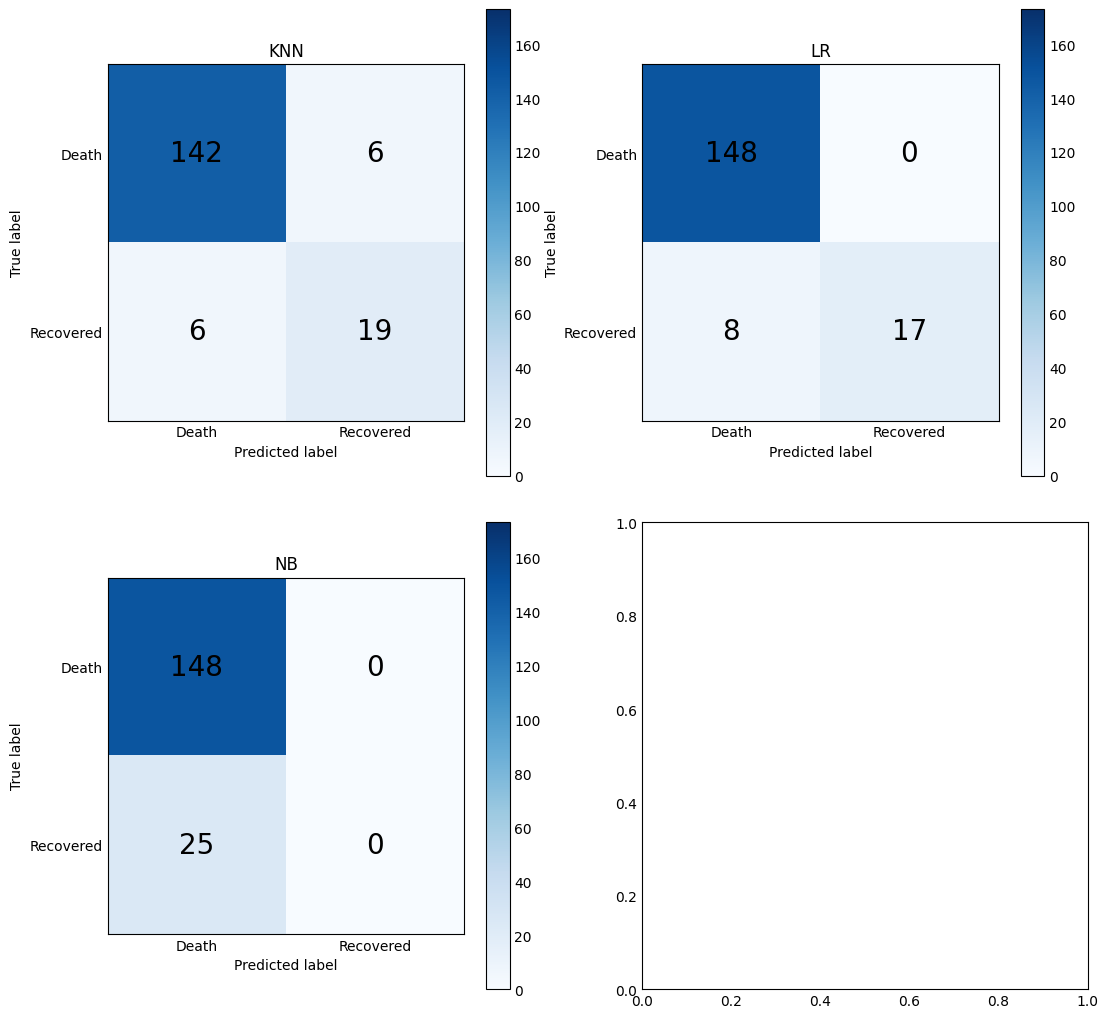

In [37]:
draw_confusion_matrices(class_names, models, X_test, y_test)

## ROC Curve

In [38]:
def draw_rocs(models: dict, X_test: np.ndarray, y_test: np.ndarray):
    plt.style.use("_mpl-gallery-nogrid")

    fig, axes = plt.subplots((len(models)//2)+1, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.2)

    np.set_printoptions(precision=2)

    for ((model_name, estimator), ax) in zip(models.items(), axes.flatten()):
        disp = RocCurveDisplay.from_estimator(
            estimator,
            X_test,
            y_test,
            ax=ax
        )
        disp.ax_.set_title(model_name)

    plt.show()

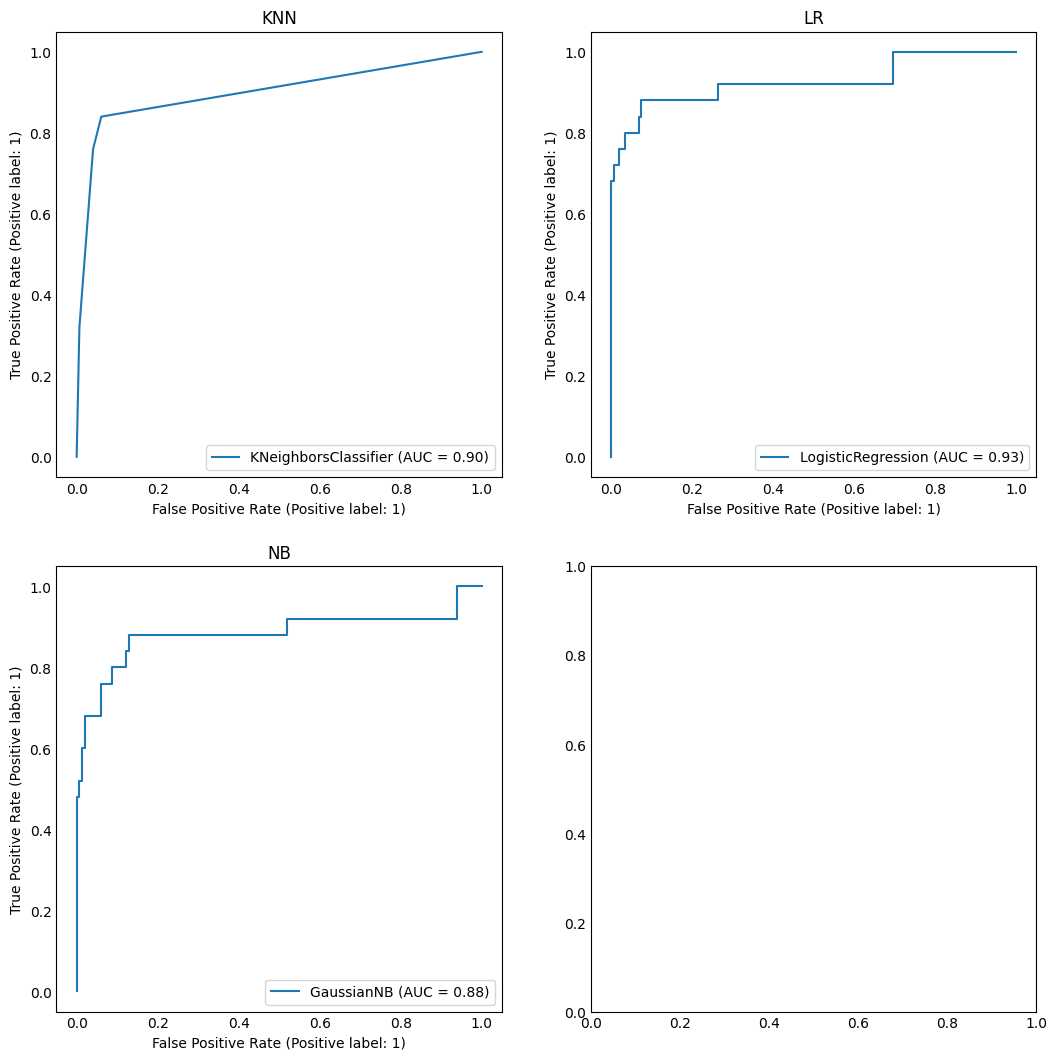

In [39]:
draw_rocs(models, X_test, y_test)

## Weights Visualization

In [40]:
# plt.style.use("_mpl-gallery-nogrid")

# fig, axes = plt.subplots((len(models)//2)+1, 2, figsize=(10, 10))
# plt.subplots_adjust(hspace=0.2)


# plt.show()

## Conclusion

As shown the Naïve Bayes model has the worst performance among the other models. The KNN and Logistic Regression models have the best performance among the other models. The LR model has the best performance among the other models.